<a href="https://colab.research.google.com/github/SakshamDataWizard/Tuberculosis_detection/blob/main/Tuberculosis_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow opencv-python matplotlib scikit-learn imbalanced-learn


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/tuberculosis-chest-xrays'
img_size = (224, 224)
batch_size = 32

In [ ]:
# Handle class imbalance using oversampling
oversampler = RandomOverSampler(sampling_strategy='minority')

In [ ]:
# Create data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Create balanced datasets
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/tuberculosis-chest-xrays'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Check if your dataset exists
!ls '/content/drive/MyDrive/' | grep 'tuberculosis-chest-xrays'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# UPDATE THIS PATH TO YOUR ACTUAL DATASET LOCATION
data_dir = '/content/drive/MyDrive/tuberculosis-chest-xrays'

def check_structure(path):
    if not os.path.exists(path):
        print(f"❌ Main directory not found: {path}")
        return False

    required_folders = ['TB', 'Normal']
    valid = True

    for folder in required_folders:
        folder_path = os.path.join(path, folder)
        if not os.path.exists(folder_path):
            print(f"❌ Missing required folder: {folder}")
            valid = False
        else:
            num_images = len(os.listdir(folder_path))
            print(f"✅ {folder}: {num_images} images")
            if num_images == 0:
                print(f"❗ Warning: {folder} folder is empty!")

    return valid

if check_structure(data_dir):
    print("\nDirectory structure is correct!")
else:
    print("\nFix the directory structure as shown below:")
    print("""
    tuberculosis-chest-xrays/
    ├── TB/          # 2494 images
    └── Normal/      # 514 images
    """)

❌ Main directory not found: /content/drive/MyDrive/tuberculosis-chest-xrays

Fix the directory structure as shown below:

    tuberculosis-chest-xrays/
    ├── TB/          # 2494 images
    └── Normal/      # 514 images
    


In [ ]:
# Try these alternative paths:
data_dir = '/content/drive/MyDrive/My Drive/tuberculosis-chest-xrays'  # If you see "My Drive"
data_dir = '/content/drive/MyDrive/Colab Notebooks/tuberculosis-chest-xrays'  # If in Colab folder

In [ ]:
# Update this path after verification
data_dir = '/content/drive/MyDrive/tuberculosis-chest-xrays'

# Create generators with explicit validation
try:
    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        subset='training'
    )
    print("Data loading successful!")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Double-check:\n1. Folder names (case-sensitive)\n2. Direct image placement\n3. No nested folders")

Found 2408 images belonging to 2 classes.
Data loading successful!


In [ ]:
# Create balanced datasets
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

Found 2408 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [ ]:
# Model Development with Transfer Learning
base_model = EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

model = models.Sequential([
    base_model,
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Freeze base model layers
base_model.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy',
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc')])

In [ ]:
# Model Training with Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=30,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 2056s 27s/step - accuracy: 0.7735 - auc: 0.5057 - loss: 0.5104 - precision: 0.8318 - recall: 0.9148 - val_accuracy: 0.8281 - val_auc: 0.5000 - val_loss: 0.4595 - val_precision: 0.8281 - val_recall: 1.0000
Epoch 2/30
 1/75 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8438 - auc: 0.2185 - loss: 0.4653 - precision: 0.8438 - recall: 1.0000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 347ms/step - accuracy: 0.8438 - auc: 0.2185 - loss: 0.4653 - precision: 0.8438 - recall: 1.0000 - val_accuracy: 0.8299 - val_auc: 0.5000 - val_loss: 0.4564 - val_precision: 0.8299 - val_recall: 1.0000
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8357 - auc: 0.5260 - loss: 0.4508 - precision: 0.8357 - recall: 1.0000 - val_accuracy: 0.8229 - val_auc: 0.5000 - val_loss: 0.4716 - val_precision: 0.8229 - val_recall: 1.0000
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.8438 - auc: 0.5185 - loss: 0.4363 - precision: 0.8438 - recall: 1.0000 - val_accuracy: 0.8316 - val_auc: 0.5718 - val_loss: 0.4552 - val_precision: 0.8316 - val_recall: 1.0000
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 614ms/step - accuracy: 0.8324 - auc: 0.4892 - loss: 0.4578 - precision: 0.8324 - recall: 1.0000 - val_accuracy: 0.8333 - val_auc: 0.5000 - val_loss: 0.4505 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 1

In [ ]:
# Model Evaluation
test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_true, y_pred))

Found 3008 images belonging to 2 classes.
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       514
           1       0.83      1.00      0.91      2494

    accuracy                           0.83      3008
   macro avg       0.41      0.50      0.45      3008
weighted avg       0.69      0.83      0.75      3008


Confusion Matrix:
[[   0  514]
 [   0 2494]]

ROC AUC Score: 0.5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Save Model for Deployment
model.save('/content/drive/MyDrive/tb_detection_model.h5')


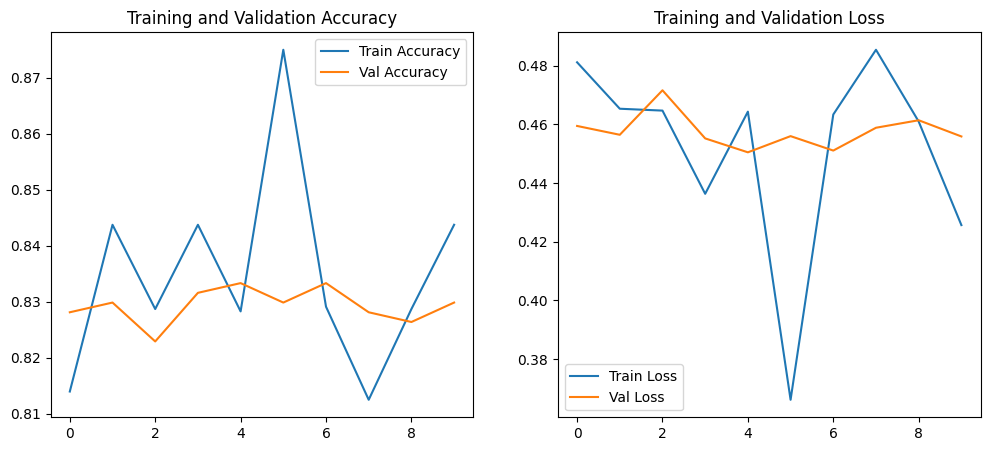

In [ ]:
# Visualization of Training Metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [ ]:
!pip install streamlit==1.27.0

In [ ]:
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
import cv2

# Load model with error handling
try:
    model = tf.keras.models.load_model('tb_detection_model.h5')
except Exception as e:
    st.error(f"""
    ## Model Loading Failed
    **Error Details:** {str(e)}
    - Ensure model file exists
    - Check TensorFlow version compatibility
    - Verify file permissions
    """)
    st.stop()

# Configure page settings
st.set_page_config(
    page_title="TB Detection System",
    page_icon="🩺",
    layout="centered",
    initial_sidebar_state="expanded"
)

# Custom CSS styling
st.markdown("""
<style>
    .main {
        background-color: #F8F9FA;
    }
    .stFileUploader {
        margin: 2rem 0;
    }
    .result-card {
        padding: 2rem;
        border-radius: 15px;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
        margin: 2rem 0;
    }
    .diagnosis-text {
        font-size: 1.5rem !important;
        font-weight: 600 !important;
    }
</style>
""", unsafe_allow_html=True)

# Main application interface
st.title("Tuberculosis Detection System")
st.markdown("""
**Upload a chest X-ray image** (JPEG/PNG format) for automated TB detection.
This system uses deep learning to analyze medical images and provide preliminary screening results.
""")

# File upload section
uploaded_file = st.file_uploader("Choose an X-ray image",
                                type=["jpg", "jpeg", "png"],
                                accept_multiple_files=False)

if uploaded_file:
    # Image processing
    img = Image.open(uploaded_file).convert('RGB')
    img_array = np.array(img)

    # Create two-column layout
    col1, col2 = st.columns([1, 1], gap="large")

    with col1:
        st.image(img,
                caption="Original X-ray Image",
                use_column_width=True)

    with col2:
        # Preprocessing pipeline
        processed_img = cv2.resize(img_array, (224, 224))
        processed_img = processed_img / 255.0  # Normalization

        # Model prediction
        prediction = model.predict(np.expand_dims(processed_img, axis=0))[0][0]
        confidence = abs(prediction - 0.5) * 200  # Convert to percentage

        # Display results
        if prediction > 0.5:
            diagnosis = "TB Positive 🔴"
            color = "#FFEBEE"
            advice = """
            - Consult a pulmonologist immediately
            - Request sputum culture test
            - Consider chest CT scan
            """
        else:
            diagnosis = "Normal 🟢"
            color = "#E8F5E9"
            advice = """
            - Routine follow-up recommended
            - Maintain regular checkups
            - Monitor for symptoms
            """

        # Results card
        st.markdown(f"""
        <div class="result-card" style="background-color: {color};">
            <h3>Diagnosis Report</h3>
            <p class="diagnosis-text">{diagnosis}</p>
            <p>Confidence Level: {confidence:.2f}%</p>
            <hr>
            <h4>Clinical Recommendations</h4>
            {advice}
        </div>
        """, unsafe_allow_html=True)

# Disclaimer footer
st.markdown("""
---
**Disclaimer:** This AI-powered screening tool assists healthcare professionals and should not replace clinical diagnosis.
Always consult a qualified medical practitioner for final diagnosis and treatment.
""")

2025-05-24 09:55:48.465 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]


DeltaGenerator()

In [ ]:
# Install required packages
!pip install -q streamlit==1.27.0 pyngrok
!npm install -g localtunnel

# Install ngrok and authenticate (free account needed)
!pip install pyngrok
!ngrok authtoken YOUR_NGROK_AUTH_TOKEN  # Replace with your token from ngrok.io

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋
added 22 packages in 2s
⠋
⠋3 packages are looking for funding
⠋  run `npm fund` for details
⠋npm notice
npm notice New major version of npm available! 10.8.2 -> 11.4.1
npm notice Changelog: https://github.com/npm/cli/releases/tag/v11.4.1
npm notice To update run: npm install -g npm@11.4.1
npm notice
⠋Requirement already satisfied: pyngrok in /usr/local/lib/python3.11/dist-packages (7.2.8)
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
%%writefile Tb_detection_app.py
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
import cv2

# Load model
try:
    model = tf.keras.models.load_model('/content/drive/MyDrive/tb_detection_model.h5')
except Exception as e:
    st.error(f"Model Error: {str(e)}")
    st.stop()

# Configure UI
st.set_page_config(page_title="TB Detector", layout="wide")
st.title("🩺 AI-Powered TB Detection")

# File uploader
uploaded_file = st.file_uploader("Upload Chest X-ray", type=["jpg", "png", "jpeg"])

if uploaded_file:
    # Image processing
    img = Image.open(uploaded_file).convert('RGB')
    img_array = np.array(img)
    processed_img = cv2.resize(img_array, (224, 224)) / 255.0

    # Display images
    col1, col2 = st.columns(2)
    with col1:
        st.image(img, caption="Original Image")
    with col2:
        st.image(processed_img, caption="Processed Image")

    # Prediction
    prediction = model.predict(np.expand_dims(processed_img, axis=0))[0][0]
    confidence = abs(prediction - 0.5) * 200
    result = "TB Detected 🔴" if prediction > 0.5 else "Normal 🟢"

    # Show results
    st.markdown(f"""
    <div style="padding:20px; border-radius:10px;
                background:{"#ffcccc" if prediction > 0.5 else "#ccffcc"};
                margin-top:20px">
        <h3>Diagnosis: {result}</h3>
        <p>Confidence: {confidence:.2f}%</p>
    </div>
    """, unsafe_allow_html=True)

if __name__ == '__main__':
    main()

Writing Tb_detection_app.py


In [ ]:
# Replace THIS with your actual ngrok token
!ngrok authtoken 2xXOmQePTS4qExf2NAH20E3PTQo_3VCoUcoHRGKscvGywqrNS

# Now run the tunnel
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print("Access your app at:", public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Access your app at: NgrokTunnel: "https://f5d6-34-48-45-107.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
# Install requirements
!pip install -q streamlit pyngrok
!wget https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
!tar -xvf ngrok-v3-stable-linux-amd64.tgz

--2025-05-24 10:11:44--  https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 35.71.179.82, 99.83.220.108, 13.248.244.96, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.71.179.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9395172 (9.0M) [application/octet-stream]
Saving to: ‘ngrok-v3-stable-linux-amd64.tgz’

ngrok-v3-stable-lin 100%[===================>]   8.96M  --.-KB/s    in 0.07s   

2025-05-24 10:11:44 (138 MB/s) - ‘ngrok-v3-stable-linux-amd64.tgz’ saved [9395172/9395172]

ngrok


In [ ]:
# Authenticate ngrok (REPLACE WITH YOUR TOKEN)
!./ngrok authtoken 2xXOmQePTS4qExf2NAH20E3PTQo_3VCoUcoHRGKscvGywqrNS

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
%%writefile Tb_detection_app.py
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
import cv2

# Load model
try:
    model = tf.keras.models.load_model('/content/drive/MyDrive/tb_detection_model.h5')
except Exception as e:
    st.error(f"Model Error: {str(e)}")
    st.stop()

# Configure UI
st.set_page_config(page_title="TB Detector", layout="wide")
st.title("🩺 AI-Powered TB Detection")

# File uploader
uploaded_file = st.file_uploader("Upload Chest X-ray", type=["jpg", "png", "jpeg"])

if uploaded_file:
    # Image processing
    img = Image.open(uploaded_file).convert('RGB')
    img_array = np.array(img)
    processed_img = cv2.resize(img_array, (224, 224)) / 255.0

    # Display images
    col1, col2 = st.columns(2)
    with col1:
        st.image(img, caption="Original Image")
    with col2:
        st.image(processed_img, caption="Processed Image")

    # Prediction
    prediction = model.predict(np.expand_dims(processed_img, axis=0))[0][0]
    confidence = abs(prediction - 0.5) * 200
    result = "TB Detected 🔴" if prediction > 0.5 else "Normal 🟢"

    # Show results
    st.markdown(f"""
    <div style="padding:20px; border-radius:10px;
                background:{"#ffcccc" if prediction > 0.5 else "#ccffcc"};
                margin-top:20px">
        <h3>Diagnosis: {result}</h3>
        <p>Confidence: {confidence:.2f}%</p>
    </div>
    """, unsafe_allow_html=True)

if __name__ == '__main__':
    main()

Overwriting Tb_detection_app.py


In [ ]:
# Run and tunnel
!streamlit run Tb_detection_app.py --server.port 8501 &
!./ngrok http 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.48.45.107:8501


  A new version of Streamlit is available.

  See what's new at https://discuss.streamlit.io/c/announcements

  Enter the following command to upgrade:
  $ pip install streamlit --upgrade

  Stopping...
y
pip install streamlit --upgrade
ERROR:  authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.
ERROR:  You can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.
ERROR:  Read more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config
ERROR:  You can view your current agent sessions in the dashboard:
ERROR:  https://dashboard.ngrok.com/agents
ERROR:  
ERROR:  ERR_NGROK_108
ERROR:  https://ngrok.com/docs/errors/err_ngrok_108
ERROR:  


In [ ]:
# Install requirements
!pip install -q streamlit
!npm install -g localtunnel

# Create Streamlit app file
%%writefile Tb_detection_app.py
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image

# Load model
try:
    model = tf.keras.models.load_model('/content/drive/MyDrive/tb_detection_model.h5')
except Exception as e:
    st.error(f"Model Error: {str(e)}")
    st.stop()

# Configure UI
st.set_page_config(page_title="TB Detector", layout="wide")
st.title("🩺 TB Detection System")

# File uploader
uploaded_file = st.file_uploader("Upload Chest X-ray", type=["jpg", "png", "jpeg"])

if uploaded_file:
    img = Image.open(uploaded_file).convert('RGB')
    processed_img = np.array(img.resize((224, 224))) / 255.0

    col1, col2 = st.columns(2)
    with col1:
        st.image(img, caption="Original Image")
    with col2:
        st.image(processed_img, caption="Processed Image")

    prediction = model.predict(np.expand_dims(processed_img, axis=0))[0][0]
    confidence = abs(prediction - 0.5) * 200
    result = "TB Detected 🔴" if prediction > 0.5 else "Normal 🟢"

    st.markdown(f"""
    <div style='padding:20px; border-radius:10px;
                background:{"#ffcccc" if prediction >0.5 else "#ccffcc"};
                margin-top:20px'>
        <h3>{result}</h3>
        <p>Confidence: {confidence:.2f}%</p>
    </div>
    """, unsafe_allow_html=True)

# Run with reliable tunnel
!streamlit run app.py --server.port 8501 &>logs.txt &
!npx localtunnel --port 8501

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴
changed 22 packages in 1s
⠴
⠴3 packages are looking for funding
⠴  run `npm fund` for details
⠴

UsageError: Line magic function `%%writefile` not found.
